In [17]:
# PyTorch Image Classification Model for Bug Bite Detection
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import os
import glob
from dotenv import load_dotenv
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load environment variables
load_dotenv()

# Get training and test folders from environment
TRAIN_FOLDER = os.getenv('TRAIN_FOLDER', 'images/run20250806_203706')
TEST_FOLDER = os.getenv('TEST_FOLDER', 'test_images')

print(f"Training folder: {TRAIN_FOLDER}")
print(f"Test folder: {TEST_FOLDER}")

# Check if folders exist
train_path = os.path.join(os.getcwd(), TRAIN_FOLDER)
test_path = os.path.join(os.getcwd(), TEST_FOLDER)

print(f"Full train path: {train_path}")
print(f"Full test path: {test_path}")
print(f"Train folder exists: {os.path.exists(train_path)}")
print(f"Test folder exists: {os.path.exists(test_path)}")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Training folder: images/run20250806_203706
Test folder: test_images
Full train path: /Users/chrisbuonocore/personal/python/dermaclassify/images/run20250806_203706
Full test path: /Users/chrisbuonocore/personal/python/dermaclassify/test_images
Train folder exists: True
Test folder exists: True
Using device: cpu


In [18]:
# Custom Dataset Class for Bug Bite Images
class BugBiteDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.images = []
        self.labels = []
        self.class_names = []

        # Find all image files and extract labels from filenames
        image_files = glob.glob(os.path.join(folder_path, "*.jpg")) + \
                     glob.glob(os.path.join(folder_path, "*.jpeg")) + \
                     glob.glob(os.path.join(folder_path, "*.png"))

        # Extract unique class names from filenames
        class_set = set()
        for img_path in image_files:
            filename = os.path.basename(img_path)
            # Extract class name (everything before the first underscore)
            if '_' in filename:
                class_name = filename.split('_')[0]
                class_set.add(class_name)

        self.class_names = sorted(list(class_set))
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(self.class_names)}

        print(f"Found classes: {self.class_names}")
        print(f"Class to index mapping: {self.class_to_idx}")

        # Process all images
        for img_path in image_files:
            filename = os.path.basename(img_path)
            if '_' in filename:
                class_name = filename.split('_')[0]
                if class_name in self.class_to_idx:
                    self.images.append(img_path)
                    self.labels.append(self.class_to_idx[class_name])

        print(f"Loaded {len(self.images)} images from {len(self.class_names)} classes")

        # Print class distribution
        label_counts = {}
        for label in self.labels:
            class_name = self.class_names[label]
            label_counts[class_name] = label_counts.get(class_name, 0) + 1

        print("Class distribution:")
        for class_name, count in label_counts.items():
            print(f"  {class_name}: {count} images")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]

        # Load image
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a black image as fallback
            image = Image.new('RGB', (224, 224), (0, 0, 0))

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        return image, label

# Define transforms for training and testing
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
print("Creating training dataset...")
train_dataset = BugBiteDataset(train_path, transform=train_transform)

print(f"\nNumber of classes: {len(train_dataset.class_names)}")
print(f"Class names: {train_dataset.class_names}")

Creating training dataset...
Found classes: ['ANT', 'BED', 'FLEA', 'MOSQUITO', 'SPIDER']
Class to index mapping: {'ANT': 0, 'BED': 1, 'FLEA': 2, 'MOSQUITO': 3, 'SPIDER': 4}
Loaded 48 images from 5 classes
Class distribution:
  MOSQUITO: 20 images
  BED: 13 images
  FLEA: 9 images
  ANT: 3 images
  SPIDER: 3 images

Number of classes: 5
Class names: ['ANT', 'BED', 'FLEA', 'MOSQUITO', 'SPIDER']


In [19]:
# CNN Model for Bug Bite Classification
class BugBiteCNN(nn.Module):
    def __init__(self, num_classes):
        super(BugBiteCNN, self).__init__()

        # Feature extraction layers
        self.features = nn.Sequential(
            # First conv block
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.25),

            # Second conv block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.25),

            # Third conv block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.25),

            # Fourth conv block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.25),
        )

        # Classifier layers
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(256, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Create model
num_classes = len(train_dataset.class_names)
model = BugBiteCNN(num_classes).to(device)

print(f"Model created with {num_classes} output classes")
print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Display model architecture
print("\nModel Architecture:")
print(model)

Model created with 5 output classes
Model parameters: 1,438,373

Model Architecture:
BugBiteCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.25, inplace=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13):

In [20]:
# Training Configuration
batch_size = 16
learning_rate = 0.001
num_epochs = 20

# Create data loaders
from sklearn.model_selection import train_test_split

# Split training data into train and validation
train_indices = list(range(len(train_dataset)))
train_idx, val_idx = train_test_split(train_indices, test_size=0.2, random_state=42,
                                      stratify=train_dataset.labels)

# Create subset datasets
train_subset = torch.utils.data.Subset(train_dataset, train_idx)
val_subset = torch.utils.data.Subset(train_dataset, val_idx)

# Create data loaders (num_workers=0 for Jupyter notebook compatibility)
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"Training samples: {len(train_subset)}")
print(f"Validation samples: {len(val_subset)}")
print(f"Batch size: {batch_size}")

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

print(f"Loss function: {criterion}")
print(f"Optimizer: {optimizer}")
print(f"Learning rate scheduler: {scheduler}")

Training samples: 38
Validation samples: 10
Batch size: 16
Loss function: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.001
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)
Learning rate scheduler: <torch.optim.lr_scheduler.StepLR object at 0x1519742b0>


In [21]:
# Training Loop
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 40)

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            if batch_idx % 5 == 0:
                print(f'Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')

        # Calculate training metrics
        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = 100 * correct_train / total_train
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        # Calculate validation metrics
        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = 100 * correct_val / total_val
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        # Update learning rate
        scheduler.step()

        print(f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%')
        print(f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%')
        print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')

    return train_losses, val_losses, train_accuracies, val_accuracies

# Check if trained model already exists
model_save_path = 'bug_bite_model.pth'

if os.path.exists(model_save_path):
    print(f"Found existing trained model: {model_save_path}")
    print("Loading pre-trained model...")

    # Load the saved model
    checkpoint = torch.load(model_save_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])

    print(f"✓ Model loaded successfully!")
    print(f"  Classes: {checkpoint['class_names']}")
    print(f"  Number of classes: {checkpoint['num_classes']}")

    # No training history when loading pre-trained model
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    print("\nSkipping training - using pre-trained model.")

else:
    print(f"No existing model found at {model_save_path}")
    print("Starting training from scratch...")

    # Train the model
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs
    )

    print("\nTraining completed!")

    # Save the trained model
    torch.save({
        'model_state_dict': model.state_dict(),
        'class_names': train_dataset.class_names,
        'num_classes': num_classes,
        'model_config': {
            'input_size': (3, 224, 224),
            'num_classes': num_classes
        }
    }, model_save_path)

    print(f"Model saved to: {model_save_path}")

Starting training...

Epoch 1/20
----------------------------------------
Batch 0/3, Loss: 1.6029
Batch 0/3, Loss: 1.6029
Train Loss: 1.5541, Train Acc: 13.16%
Val Loss: 1.5844, Val Acc: 30.00%
Learning Rate: 0.001000

Epoch 2/20
----------------------------------------
Train Loss: 1.5541, Train Acc: 13.16%
Val Loss: 1.5844, Val Acc: 30.00%
Learning Rate: 0.001000

Epoch 2/20
----------------------------------------
Batch 0/3, Loss: 1.4934
Batch 0/3, Loss: 1.4934
Train Loss: 1.3994, Train Acc: 39.47%
Val Loss: 1.5205, Val Acc: 40.00%
Learning Rate: 0.001000

Epoch 3/20
----------------------------------------
Train Loss: 1.3994, Train Acc: 39.47%
Val Loss: 1.5205, Val Acc: 40.00%
Learning Rate: 0.001000

Epoch 3/20
----------------------------------------
Batch 0/3, Loss: 1.3796
Batch 0/3, Loss: 1.3796
Train Loss: 1.3085, Train Acc: 42.11%
Val Loss: 1.4482, Val Acc: 40.00%
Learning Rate: 0.001000

Epoch 4/20
----------------------------------------
Train Loss: 1.3085, Train Acc: 42.11%

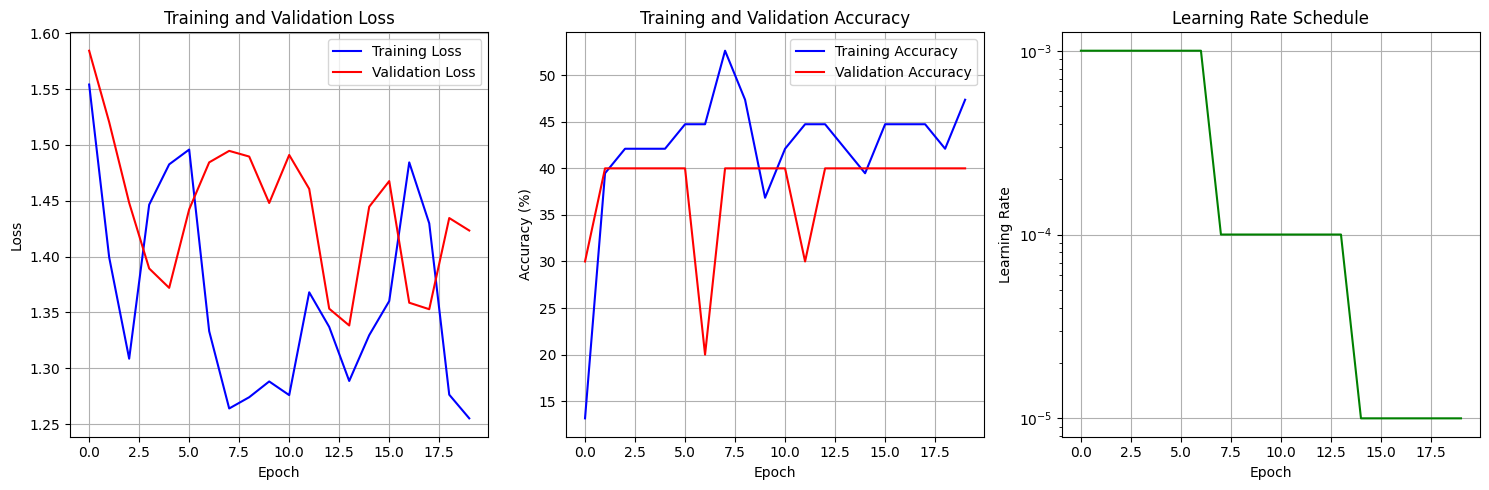


Final Training Results:
Final Training Accuracy: 47.37%
Final Validation Accuracy: 40.00%
Best Validation Accuracy: 40.00%

Model ready for predictions!


In [22]:
# Plot training progress (or show placeholder for loaded model)
if len(train_losses) > 0:  # We actually trained the model
    plt.figure(figsize=(15, 5))

    # Plot loss
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='red')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot accuracy
    plt.subplot(1, 3, 2)
    plt.plot(train_accuracies, label='Training Accuracy', color='blue')
    plt.plot(val_accuracies, label='Validation Accuracy', color='red')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    # Plot learning rate
    plt.subplot(1, 3, 3)
    lrs = []
    for epoch in range(num_epochs):
        if epoch < 7:
            lrs.append(learning_rate)
        elif epoch < 14:
            lrs.append(learning_rate * 0.1)
        else:
            lrs.append(learning_rate * 0.01)

    plt.plot(lrs, color='green')
    plt.title('Learning Rate Schedule')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.yscale('log')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Print final results
    print(f"\nFinal Training Results:")
    print(f"Final Training Accuracy: {train_accuracies[-1]:.2f}%")
    print(f"Final Validation Accuracy: {val_accuracies[-1]:.2f}%")
    print(f"Best Validation Accuracy: {max(val_accuracies):.2f}%")
else:
    print("\nUsing pre-trained model - no training curves to display.")
    print("Model is ready for inference!")

print(f"\nModel ready for predictions!")


Making predictions on test images from: /Users/chrisbuonocore/personal/python/dermaclassify/test_images
Found 3 test images

Processing: test1.jpg
  Predicted class: MOSQUITO
  Confidence: 0.4701 (47.01%)
  Top 3 predictions:
    1. MOSQUITO: 0.4701 (47.01%)
    2. BED: 0.2418 (24.18%)
    3. FLEA: 0.1739 (17.39%)
----------------------------------------
Processing: test3.jpg
  Predicted class: MOSQUITO
  Confidence: 0.4215 (42.15%)
  Top 3 predictions:
    1. MOSQUITO: 0.4215 (42.15%)
    2. BED: 0.2438 (24.38%)
    3. FLEA: 0.1884 (18.84%)
Found 3 test images

Processing: test1.jpg
  Predicted class: MOSQUITO
  Confidence: 0.4701 (47.01%)
  Top 3 predictions:
    1. MOSQUITO: 0.4701 (47.01%)
    2. BED: 0.2418 (24.18%)
    3. FLEA: 0.1739 (17.39%)
----------------------------------------
Processing: test3.jpg
  Predicted class: MOSQUITO
  Confidence: 0.4215 (42.15%)
  Top 3 predictions:
    1. MOSQUITO: 0.4215 (42.15%)
    2. BED: 0.2438 (24.38%)
    3. FLEA: 0.1884 (18.84%)
-------

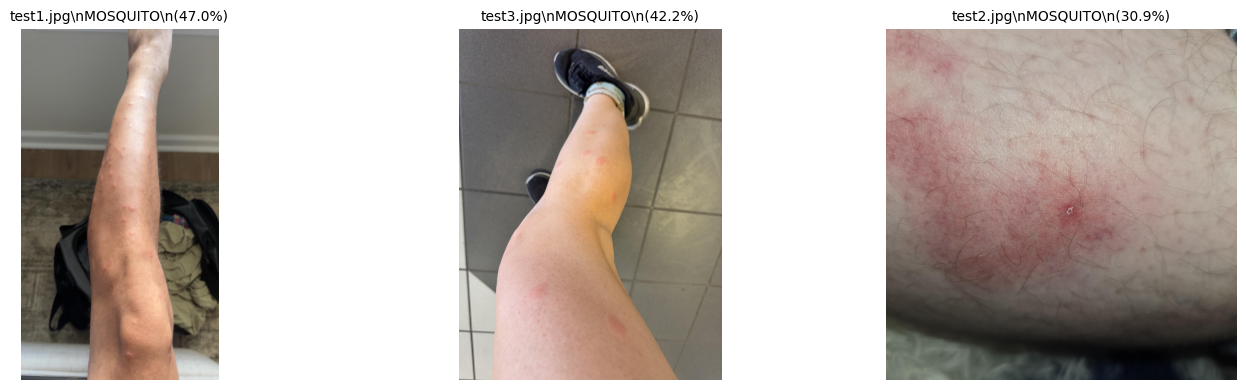

\nPREDICTION SUMMARY:
File: test1.jpg
  → MOSQUITO (confidence: 47.01%)
  Top 3: MOSQUITO (47.0%), BED (24.2%), FLEA (17.4%)

File: test3.jpg
  → MOSQUITO (confidence: 42.15%)
  Top 3: MOSQUITO (42.2%), BED (24.4%), FLEA (18.8%)

File: test2.jpg
  → MOSQUITO (confidence: 30.89%)
  Top 3: MOSQUITO (30.9%), BED (25.3%), FLEA (20.7%)

Total predictions made: 3


In [23]:
# Test Image Prediction Function
def predict_image(model, image_path, class_names, transform, device):
    """Predict the class of a single image"""
    model.eval()

    # Load and preprocess image
    try:
        image = Image.open(image_path).convert('RGB')
        image_tensor = transform(image).unsqueeze(0).to(device)

        # Make prediction
        with torch.no_grad():
            outputs = model(image_tensor)
            probabilities = F.softmax(outputs, dim=1)
            confidence, predicted = torch.max(probabilities, 1)

        predicted_class = class_names[predicted.item()]
        confidence_score = confidence.item()

        # Get top 3 predictions
        top3_prob, top3_indices = torch.topk(probabilities, 3, dim=1)
        top3_classes = [(class_names[idx.item()], prob.item())
                       for idx, prob in zip(top3_indices[0], top3_prob[0])]

        return predicted_class, confidence_score, top3_classes, image

    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None, None, None, None

# Test on all images in TEST_FOLDER
print(f"\nMaking predictions on test images from: {test_path}")
print("=" * 60)

test_image_files = glob.glob(os.path.join(test_path, "*.jpg")) + \
                   glob.glob(os.path.join(test_path, "*.jpeg")) + \
                   glob.glob(os.path.join(test_path, "*.png"))

if not test_image_files:
    print(f"No test images found in {test_path}")
else:
    print(f"Found {len(test_image_files)} test images\n")

    # Set up plotting for test results
    num_test_images = len(test_image_files)
    if num_test_images > 0:
        fig, axes = plt.subplots(1, min(num_test_images, 4), figsize=(15, 4))
        if num_test_images == 1:
            axes = [axes]
        elif num_test_images < 4:
            axes = axes[:num_test_images]

    predictions_summary = []

    for idx, image_path in enumerate(test_image_files):
        filename = os.path.basename(image_path)
        print(f"Processing: {filename}")

        predicted_class, confidence, top3_classes, image = predict_image(
            model, image_path, train_dataset.class_names, test_transform, device
        )

        if predicted_class is not None:
            print(f"  Predicted class: {predicted_class}")
            print(f"  Confidence: {confidence:.4f} ({confidence*100:.2f}%)")
            print(f"  Top 3 predictions:")
            for i, (class_name, prob) in enumerate(top3_classes):
                print(f"    {i+1}. {class_name}: {prob:.4f} ({prob*100:.2f}%)")

            # Store prediction for summary
            predictions_summary.append({
                'filename': filename,
                'predicted_class': predicted_class,
                'confidence': confidence,
                'top3': top3_classes
            })

            # Plot image with prediction if we have space
            if idx < min(num_test_images, 4):
                if num_test_images > 1:
                    ax = axes[idx]
                else:
                    ax = axes[0]

                ax.imshow(image)
                ax.set_title(f'{filename}\\n{predicted_class}\\n({confidence*100:.1f}%)',
                           fontsize=10)
                ax.axis('off')

        print("-" * 40)

    if num_test_images > 0:
        plt.tight_layout()
        plt.show()

    # Print summary of all predictions
    print("\\nPREDICTION SUMMARY:")
    print("=" * 60)
    for pred in predictions_summary:
        print(f"File: {pred['filename']}")
        print(f"  → {pred['predicted_class']} (confidence: {pred['confidence']*100:.2f}%)")
        print(f"  Top 3: {', '.join([f'{cls} ({prob*100:.1f}%)' for cls, prob in pred['top3']])}")
        print()

    print(f"Total predictions made: {len(predictions_summary)}")